In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time
import torch.nn as nn
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from tqdm.autonotebook import tqdm, trange
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
class TomatoDataset(Dataset):
    """Dataset Томатов"""
    
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_classes = list(sorted(os.listdir(root_dir)))
        self.img_path_list = []
        for one_class in self.list_classes:
            count_img = list(os.listdir(os.path.join(root_dir,
                                                     one_class)))
            for img in count_img:
                self.img_path_list.append(os.path.join(one_class,img))
        self.transform = transform
        self.img_list = np.empty([len(self.img_path_list), 256, 256, 3], dtype=np.uint8)
        for i, path in enumerate(self.img_path_list):
            self.img_list[i] = self.__get_img_by_path(os.path.join(root_dir, path))   
            
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        target = self.list_classes.index(os.path.dirname(self.img_path_list[index]))
        sample = {'image': self.img_list[index], 'target': target}
    
        if self.transform:
            sample["image"] = self.transform(self.img_list[index])
    
        return sample
    
    def __get_img_by_path(self, img_path):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = np.array(img)
        return img

In [3]:
train = TomatoDataset("../dataset/train",transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomResizedCrop(244),
                                    transforms.RandomHorizontalFlip(),
                                  ]),)

In [4]:
valid = TomatoDataset("../dataset/valid", transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(244)]))

In [14]:
valid_size = int(0.2 * dataset_size)
test_size  = int(0.11 * dataset_size)

18345

In [15]:
from sklearn.model_selection import train_test_split

In [17]:
train_split, test_split = train_test_split(train, test_size=0.11, random_state=42)

In [5]:
test = TomatoDataset("../dataset/test",transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(244)]))

In [18]:
train_dl = DataLoader(train_split, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid, batch_size=10, shuffle=True)
test_dl = DataLoader(test_split, batch_size=10, shuffle=True)

In [7]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for target in tqdm(train_dl):
            xb, yb = target['image'].to(device), target['target'].to(device)
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for target in tqdm(valid_dl):
                xb, yb = target['image'].to(device), target['target'].to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [8]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [9]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [20]:
resnet18_two = models.resnet18(pretrained=True)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False
#разморозили три слоя слой  
for param in resnet18_two.layer2.parameters():
    param.requires_grad = True
for param in resnet18_two.layer3.parameters():
    param.requires_grad = True
for param in resnet18_two.layer4.parameters():
    param.requires_grad = True    
    
resnet18_two.fc = nn.Linear(in_features=512, out_features=10, bias=True)
    
resnet18_two = resnet18_two.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(resnet18_two.layer2.parameters()) + 
                       list(resnet18_two.layer3.parameters()) +
                       list(resnet18_two.layer4.parameters()) +
                       list(resnet18_two.fc.parameters()), lr=0.01)

resnet18_two_inf = fit(20,resnet18_two, loss_fn, optimizer, train_dl, valid_dl)

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

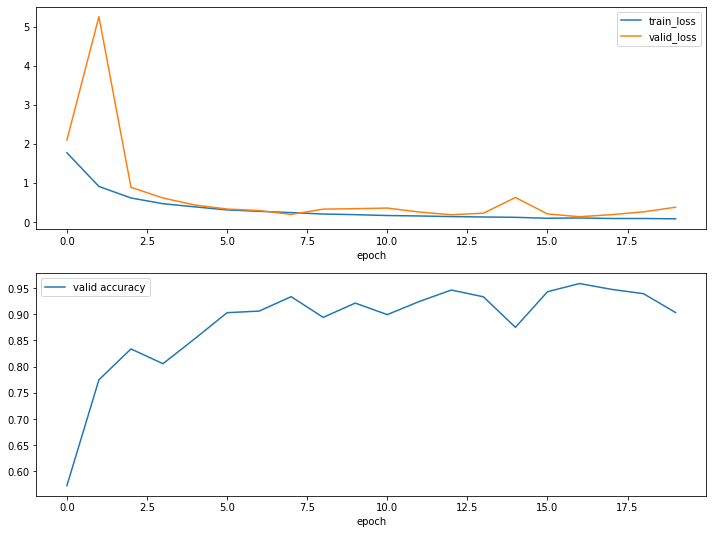

In [21]:
plot_trainig(*resnet18_two_inf)

In [34]:
torch.save(resnet18_two.state_dict(), 'resnet18_two.pth')

In [22]:
test_accuracies = []
model = resnet18_two
model.eval()
correct = 0
num = 0
with torch.no_grad():
    for target in tqdm(test_dl):
        xb, yb = target['image'].to(device), target['target'].to(device)

        probs = model(xb)

        _, preds = torch.max(probs, axis=-1)
        correct += (preds == yb).sum().item()
        num += len(xb)

test_accuracies.append(correct / num)

  0%|          | 0/202 [00:00<?, ?it/s]

In [23]:
print("accuracies:",test_accuracies)

accuracies: [0.9013875123885035]


In [27]:
model_efficient = models.efficientnet_b1()

# # Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_efficient.features[:-4].parameters():
    param.requires_grad = False
# #разморозили один слой  
# for param in resnet18.conv1.parameters():
#     param.requires_grad = True
# for param in resnet18.bn1.parameters():
#     param.requires_grad = True
# for param in resnet18.layer4.parameters():
#     param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
model_efficient.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=num_features, out_features=10, bias=True),
  )

# Использовать ли GPU
model_efficient.to(device)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_efficient.parameters(), lr=0.05)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = fit(20,model_efficient, loss_fn, optimizer, train_dl, valid_dl)

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

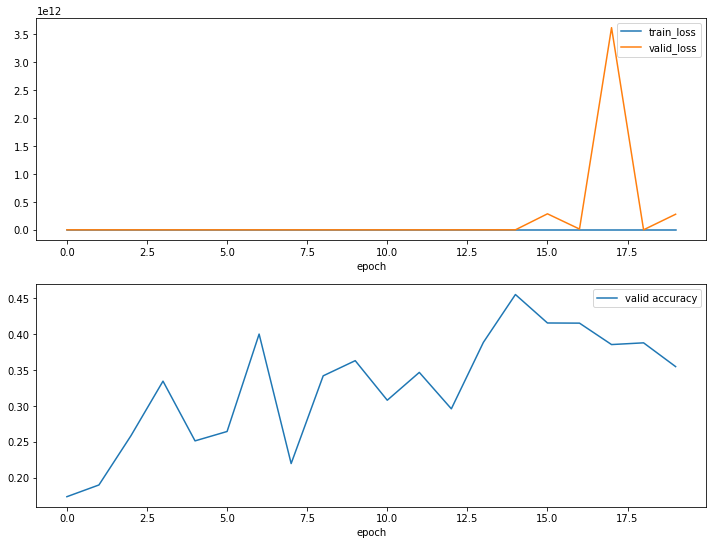

In [28]:
plot_trainig(*exp_lr_scheduler)

In [29]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 5, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(6272, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn1(nn.functional.max_pool2d(nn.functional.relu(self.conv1(x)), 2))
        x = self.bn2(nn.functional.max_pool2d(nn.functional.relu(self.conv2(x)), 2))
        x = self.bn3(nn.functional.max_pool2d(nn.functional.relu(self.conv3(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn4(nn.functional.relu(self.fc1(x)))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/459 [00:00<?, ?it/s]

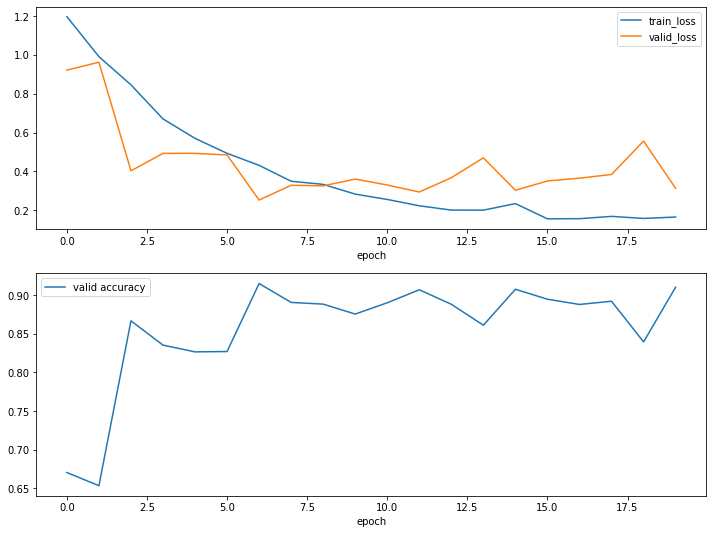

In [31]:
model1 = Model1().to(device)
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

info1 = fit(20, model1, loss_fn1, optimizer1,train_dl, valid_dl)
plot_trainig(*info1)

In [32]:
test_accuracies = []
model = model1
model.eval()
correct = 0
num = 0
with torch.no_grad():
    for target in tqdm(test_dl):
        xb, yb = target['image'].to(device), target['target'].to(device)

        probs = model(xb)

        _, preds = torch.max(probs, axis=-1)
        correct += (preds == yb).sum().item()
        num += len(xb)

test_accuracies.append(correct / num)

  0%|          | 0/202 [00:00<?, ?it/s]

In [33]:
print("accuracies:",test_accuracies)

accuracies: [0.8543111992071358]


In [35]:
torch.save(resnet18_two.state_dict(), 'mymodel.pth')